### Required Libs and Methods


In [1]:
import os, sys
import pickle
import networkx as nx

import numpy as np
import seaborn as sns

from typing import List, Dict
from matplotlib import pyplot as plt

sys.path.append('..')
from utils import calculate_edge_entropy

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid", {
    "xtick.major.size": 0.1,
    "ytick.major.size": 0.1,
    'grid.linestyle': '--'
 })

sns.despine()

colors = ["blue", "green", "orange", "purple", "darkblue", "pink", "black", "brown", "cyan", "darkblue"]
rounds = np.arange(start=1, stop=10 + 1, step=1)


def retrieve_federated_data(stored_results_dict, metric='SHD', plot_target='round_metrics') -> np.ndarray:
    """ Return federated information for a specific target.
    
    Note: default is to return information for prior, or the end of the round results.
    """
    return np.asarray([np.array(target_dict[metric], dtype=np.int32) for target_dict in stored_results_dict[plot_target]])


def plot_cluster_experiments_subplots(axs, subplot_idx, num_experiments, repeat_count, 
                                      labels_list, parent_folder_name, 
                                      exps_folder_name, ignore_ids=list(), plot_metric="SHD", 
                                      plot_target='round_metrics', num_rounds=10, std_exageration=1, 
                                      single_legend=False):
    """Plot experiments in a subplot mode"""

    colors = ["blue", "green", "orange", "purple", "darkblue", "pink", "black", "brown", "cyan", "darkblue"]
    rounds = np.arange(start=1, stop=num_rounds + 1, step=1)

    row, col = subplot_idx[0], subplot_idx[1]
    for experiment_id in range(num_experiments):
            if experiment_id in ignore_ids: continue
            
            metrics = list()
            for rep_idx in range(repeat_count):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                metrics.append(retrieve_federated_data(results_dict, plot_metric, plot_target))

            metrics_avg = np.mean(np.asarray(metrics), axis=0)
            metrics_std = np.std(np.asarray(metrics), axis=0)

            axs[row, col].plot(rounds, metrics_avg, label=labels_list[experiment_id], linestyle='solid', marker='o')
            axs[row, col].fill_between(rounds, metrics_avg - std_exageration * metrics_std,
                                      (metrics_avg + std_exageration * metrics_std),
                                       alpha=0.1)
            
            if single_legend:
                axs[0, n_col - 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                axs[row, col].legend(loc='best')

            axs[row, 0].set_ylabel(plot_metric, fontsize=14)
            axs[n_row - 1, col].set_xlabel('Round', fontsize=14)
            axs[row, col].set_xlim([0.5, 10.5])
            
            start, end = axs[row, col].get_ylim()
            axs[row, col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
            axs[row, col].xaxis.set_ticks(np.arange(1, 11, 1).astype(int))

<Figure size 432x288 with 0 Axes>

### Balanced Interventions naive method structured and rnd graphs




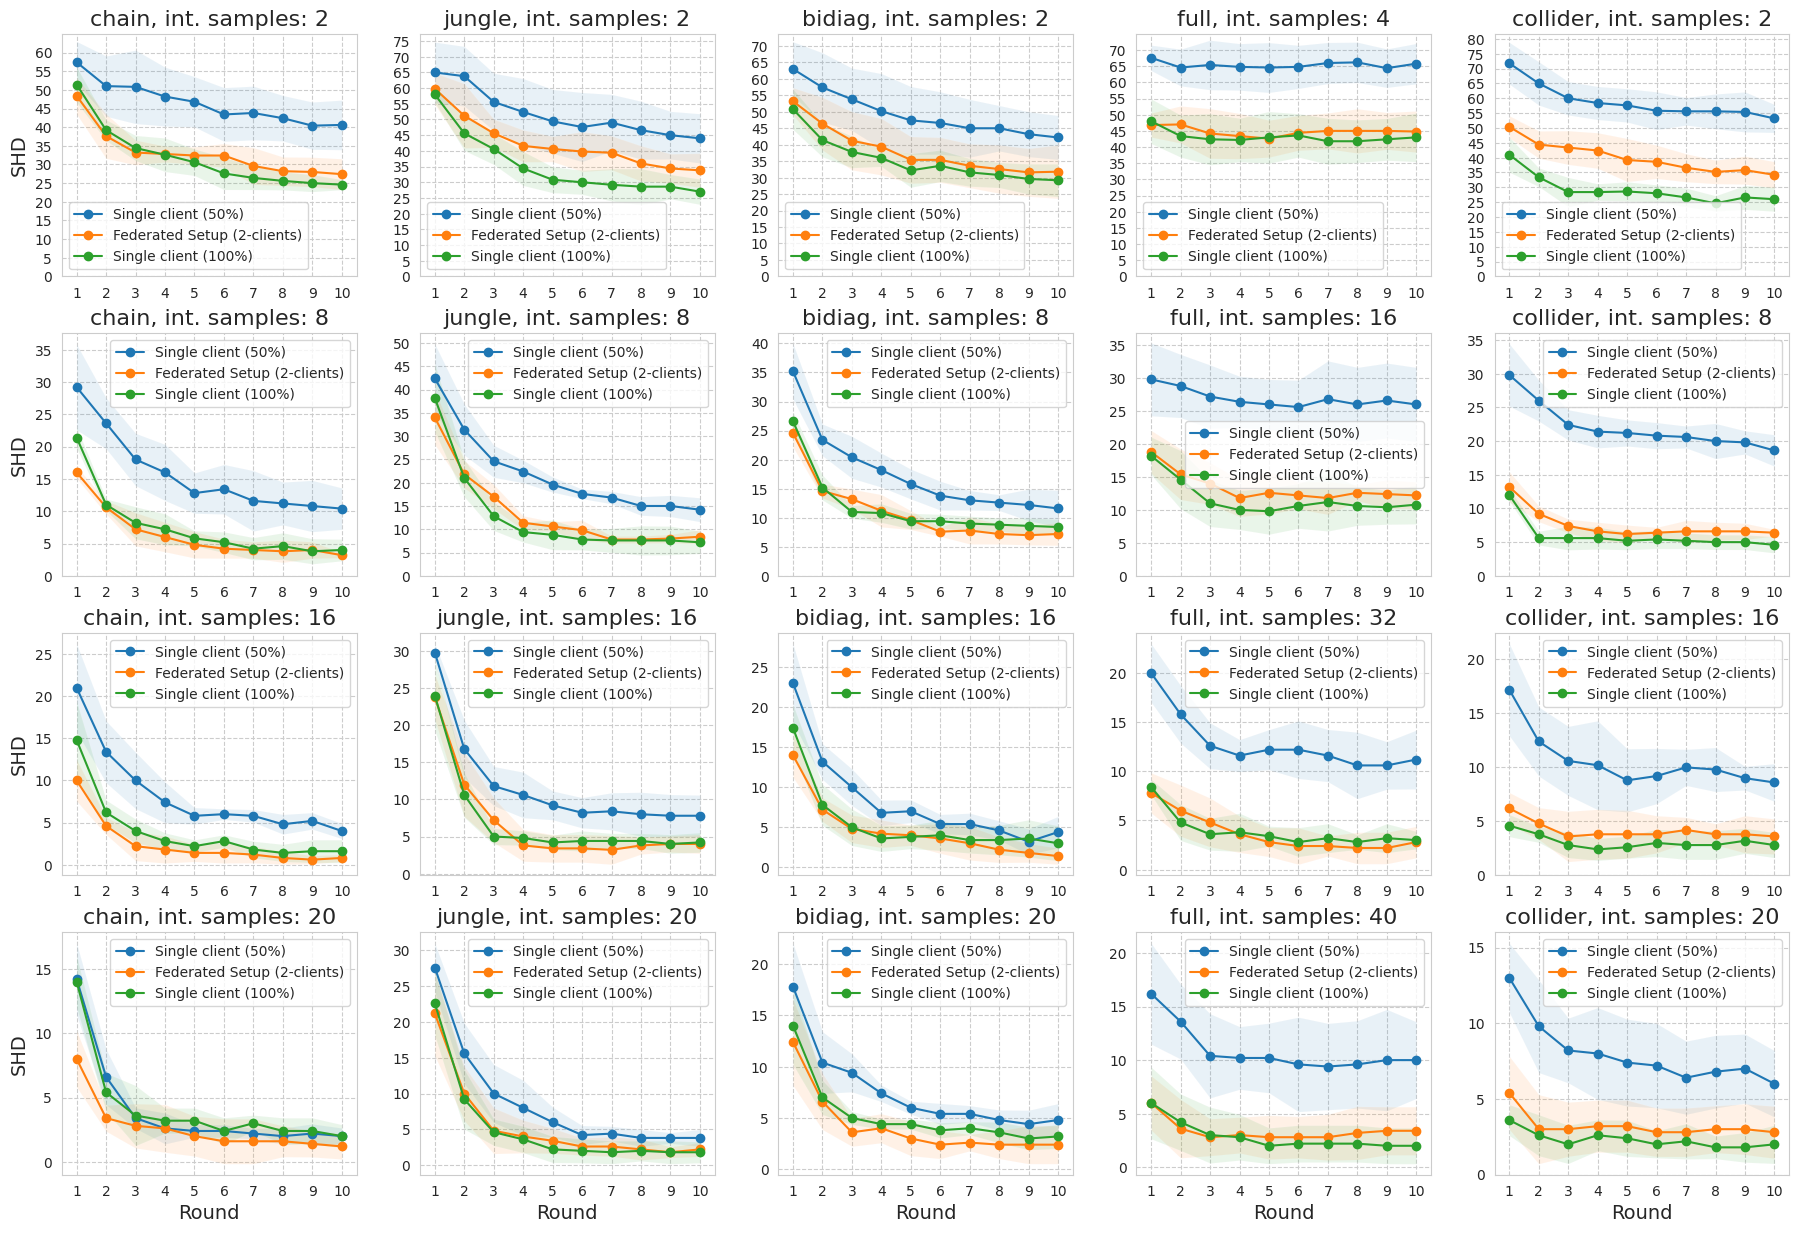

In [10]:
# General Setup
num_experiments, repeat_count = 3, 5
num_vars = 20

# Specific Setup
int_sample_sizes = [5, 10, 20, 40, 60, 80, 100, 120, 160, 200]
experiment_graphs = "str"

# Graphs
graph_types = ["chain", "jungle", "bidiag", "full", "collider"]  
edge_probs = [0.1, 0.2, 0.4, 0.6, 0.8]

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "" if experiment_graphs == "str" else "ep: "

labels = [f'Single client (50%)', 'Federated Setup (2-clients)', "Single client (100%)"]

parent_folder_name = 'naive_agg'
specifiers = [1, 4, 8, 10] # PLOT READY [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

n_row = len(specifiers)
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 12), dpi=100)
fig.tight_layout(h_pad=2, w_pad=1.5)

init_samples = [2, 2, 2, 4, 2] if experiment_graphs == "str" else [2, 3, 4, 5, 6]
for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        axs[row, col].set_title(f'{title}{graph}, int. samples: {specifier * init_samples[col]}', fontsize=16)
        exps_folder_name = f'BalancedSetup-{graph}-{num_vars}-{specifier}'
        plot_cluster_experiments_subplots (axs, (row, col), num_experiments, repeat_count, 
                                           labels, parent_folder_name, 
                                           exps_folder_name, plot_target='round_metrics')

plt.savefig(f'balanced_int_aggregation_{experiment_graphs}.png', bbox_inches='tight')
plt.show()


#### Structured graphs, plot per int

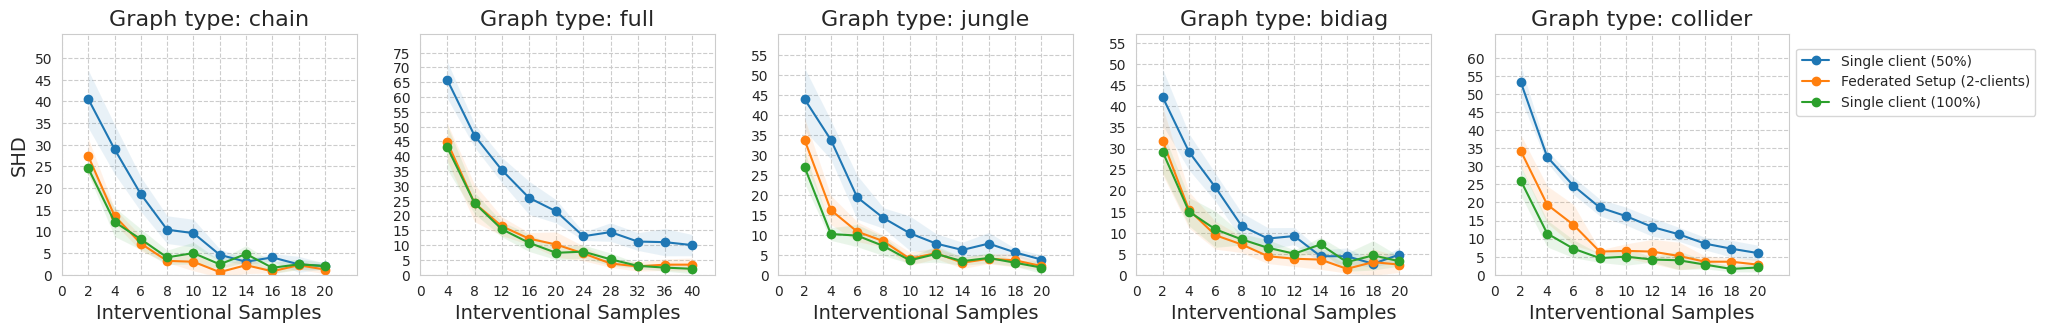

In [2]:
# General Setup
num_experiments, repeat_count = 3, 5
num_vars = 20

# Graphs
graphs = ["chain", "full", "jungle", "bidiag", "collider"]  
experiment_graphs = "str"

# Build experiments info
parent_folder_name = 'naive_agg'
specifiers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
int_samples_others = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
full_samples = (2 * np.array(int_samples_others)).astype(int)
labels = [f'Single client (50%)', 'Federated Setup (2-clients)', "Single client (100%)"]

n_row = 1
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 3), dpi=100)
fig.tight_layout(h_pad=1, w_pad=1.5)

for col, graph in enumerate(graphs):
    int_samples = full_samples if graph == 'full' else int_samples_others
    axs[col].set_title(f'Graph type: {graph}', fontsize=16)
    
    for experiment_id in range(num_experiments):
        shd_per_int_samples_list = list()

        for rep_idx in range(repeat_count):
            shd_per_int_samples = list()
            for specifier in specifiers: 
                exps_folder_name = f'BalancedSetup-{graph}-{num_vars}-{specifier}'

                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                shd_per_rounds = retrieve_federated_data(results_dict, "SHD", "round_metrics")
                shd_per_int_samples.append(shd_per_rounds[-1])

            shd_per_int_samples_list.append(shd_per_int_samples)

        shd_per_int_samples_avg = np.mean(np.asarray(shd_per_int_samples_list), axis=0)
        shd_per_int_samples_std = np.std(np.asarray(shd_per_int_samples_list), axis=0)

        axs[col].plot(int_samples, shd_per_int_samples_avg, label=labels[experiment_id], 
                      linestyle='solid', marker='o')
        axs[col].fill_between(int_samples, shd_per_int_samples_avg - shd_per_int_samples_std,
                              (shd_per_int_samples_avg +  shd_per_int_samples_std),
                               alpha=0.1)

        axs[0].set_ylabel("SHD", fontsize=14)
        axs[col].set_xlabel('Interventional Samples', fontsize=14)
        
        start_x, end_x = axs[col].get_xlim()
        start_y, end_y = axs[col].get_ylim()

        axs[col].set_xlim([start_x + 0.5, end_x + 0.5])
        axs[col].set_ylim([0, end_y + 2])

        axs[col].yaxis.set_ticks(np.arange(0, end_y, 5).astype(int))
        if graph == "full":  axs[col].xaxis.set_ticks(np.arange(0, end_x, 4).astype(int))
        else: axs[col].xaxis.set_ticks(np.arange(0, end_x, 2).astype(int))
axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

plt.savefig(f'balanced_int_{experiment_graphs}_shd_per_samples.png', bbox_inches='tight')
plt.show()


#### Random graphs, plot per int

In [ ]:
# General Setup
num_experiments, repeat_count = 3, 5
num_vars = 20

# Graphs
edge_probs = [0.1, 0.2, 0.4, 0.6, 0.8]
graphs = edge_probs
experiment_graphs = "rnd"

# Build experiments info
parent_folder_name = 'naive_agg'
specifiers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
int_sample_sizes = [2, 3, 4, 5, 6]
labels = [f'Single client (50%)', 'Federated Setup (2-clients)', "Single client (100%)"]

n_row = 1
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 3), dpi=100)
fig.tight_layout(h_pad=1, w_pad=1.5)

for col, graph in enumerate(graphs):
    int_samples = [int_sample_sizes[col] * spc for spc in specifiers]
    axs[col].set_title(f'Edge prob.: {graph}', fontsize=16)
    
    for experiment_id in range(num_experiments):
        shd_per_int_samples_list = list()

        for rep_idx in range(repeat_count):
            shd_per_int_samples = list()
            for specifier in specifiers: 
                exps_folder_name = f'BalancedSetup-{graph}-{num_vars}-{specifier}'

                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                shd_per_rounds = retrieve_federated_data(results_dict, "SHD", "round_metrics")
                shd_per_int_samples.append(shd_per_rounds[-1])

            shd_per_int_samples_list.append(shd_per_int_samples)

        shd_per_int_samples_avg = np.mean(np.asarray(shd_per_int_samples_list), axis=0)
        shd_per_int_samples_std = np.std(np.asarray(shd_per_int_samples_list), axis=0)

        axs[col].plot(int_samples, shd_per_int_samples_avg, label=labels[experiment_id], 
                      linestyle='solid', marker='o')
        axs[col].fill_between(int_samples, shd_per_int_samples_avg - shd_per_int_samples_std,
                              (shd_per_int_samples_avg +  shd_per_int_samples_std),
                               alpha=0.1)

        axs[0].set_ylabel("SHD", fontsize=14)
        axs[col].set_xlabel('Interventional Samples', fontsize=14)
        
        start_x, end_x = axs[col].get_xlim()
        start_y, end_y = axs[col].get_ylim()

        axs[col].set_xlim([start_x + 0.5, end_x + 0.5])
        axs[col].set_ylim([0, end_y + 2])

        axs[col].yaxis.set_ticks(np.arange(0, end_y, 5).astype(int))
        axs[col].xaxis.set_ticks(np.arange(0, end_x, int_sample_sizes[col]).astype(int))
axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

plt.savefig(f'balanced_int_{experiment_graphs}_shd_per_samples.png', bbox_inches='tight')
plt.show()


### Client number effect balanced scenario


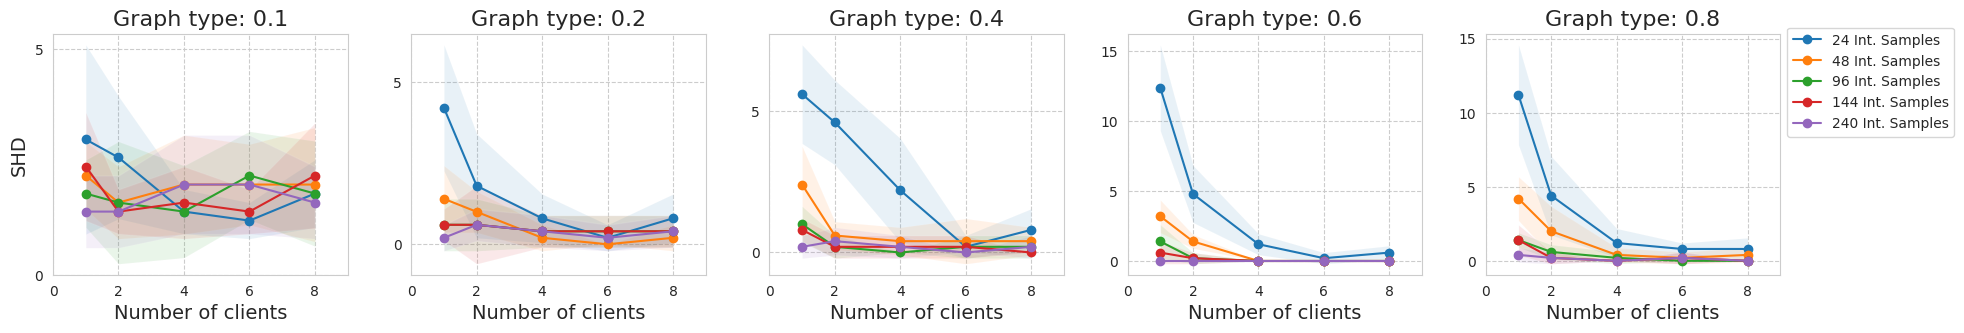

In [37]:
# General Setup
num_experiments, repeat_count = 5, 5
num_vars = 20

# Graphs
graph_types = ["full", "chain", "jungle", "bidiag", "collider"]  
edge_probs = [0.1, 0.2, 0.4, 0.6, 0.8]
experiment_graphs = "rnd"
division_type = "NODIV"

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs

# Build experiments info
parent_folder_name = 'client_sweep'
ref_num_clients = [1, 2, 4, 6, 8]

n_row = 1
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 3), dpi=100)
fig.tight_layout(h_pad=1, w_pad=1.5)

for col, graph in enumerate(graphs):
    int_samples = [24, 48, 96, 144, 240]
    axs[col].set_title(f'Graph type: {graph}', fontsize=16)

    for int_sample in int_samples:
        exps_folder_name = f'ClientSweep{division_type}-{graph}-{num_vars}-{int_sample}'
        
        shd_per_numclients = list()
        for rep_idx in range(repeat_count):
            shd_per_clients = list()
            
            for experiment_id in range(num_experiments):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                shd_per_rounds = retrieve_federated_data(results_dict, "SHD", "round_metrics")
                shd_per_clients.append(shd_per_rounds[-1])
            
            shd_per_numclients.append(shd_per_clients)

        shd_per_numclients_avg = np.mean(np.asarray(shd_per_numclients), axis=0)
        shd_per_numclients_std = np.std(np.asarray(shd_per_numclients), axis=0)

        axs[col].plot(ref_num_clients, shd_per_numclients_avg, label=f'{int_sample} Int. Samples', 
                      linestyle='solid', marker='o')
        axs[col].fill_between(ref_num_clients, shd_per_numclients_avg - shd_per_numclients_std,
                              (shd_per_numclients_avg +  shd_per_numclients_std),
                               alpha=0.1)
        
        axs[0].set_ylabel("SHD", fontsize=14)
        axs[col].set_xlabel('Number of clients', fontsize=14)
        axs[col].set_xlim([0, 9])

        start, end = axs[col].get_ylim()
        axs[col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
        axs[col].xaxis.set_ticks(np.arange(0, 10, 2).astype(int))
axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

plt.savefig(f'client_sweep_balanced_agg_shd_per_clients_{experiment_graphs}_{division_type}.png', bbox_inches='tight')
plt.show()

### Toy experiments with structured and random graphs

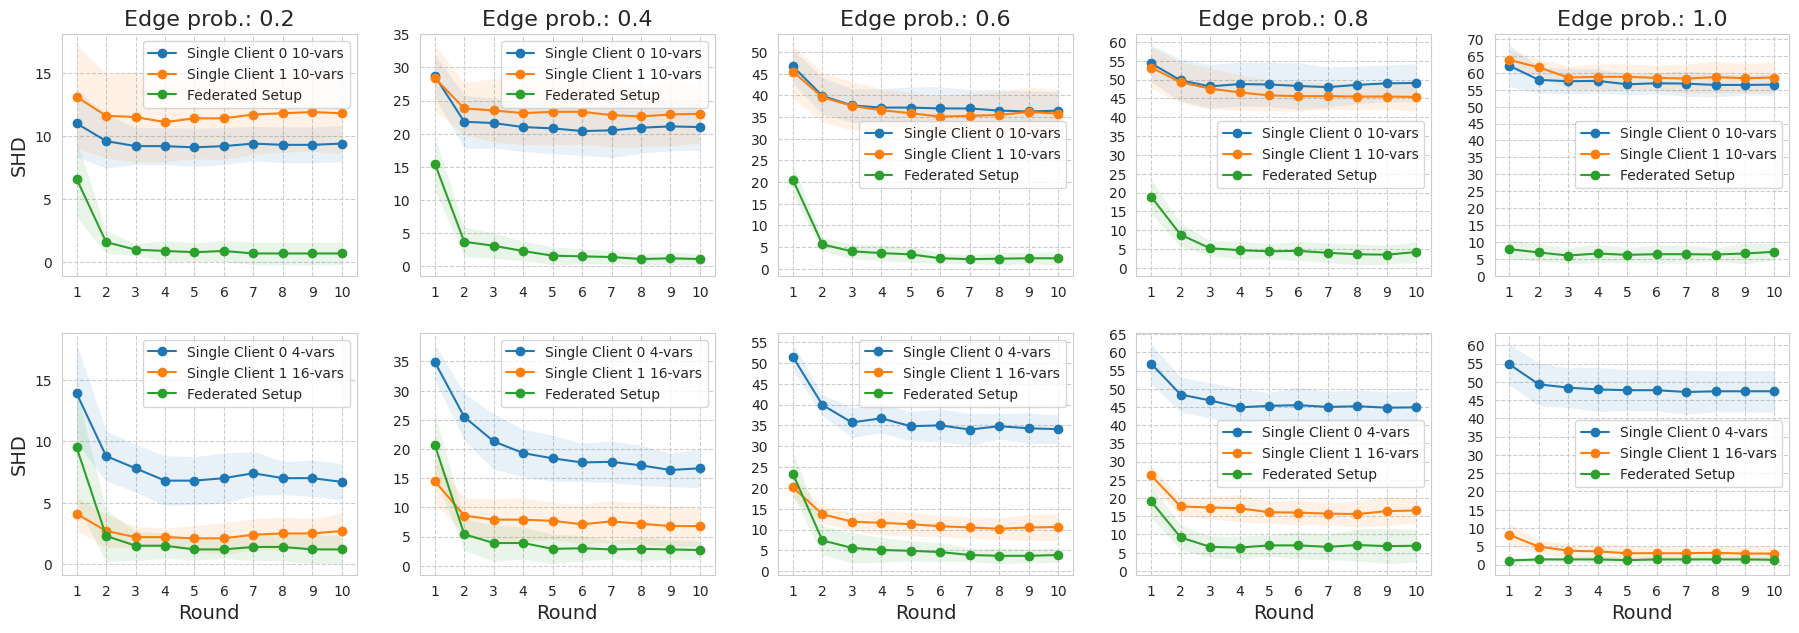

In [47]:
# General Setup
num_experiments, num_rounds, repeat_count, plot_metric, std_exageration = 3, 10, 10, "SHD", 1
num_vars = 20

# Specific Setup
experiment_graphs = "rnd"
splits = [(50, 50), (20, 80)]

# Graphs
graph_types = ["chain", "jungle", "full", "collider", "bidiag"]  
edge_probs = [0.2, 0.4, 0.6, 0.8, 1.0]

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "Graph type: " if experiment_graphs == "str" else "Edge prob.: "

intervention_labels = [[f'Single Client 0 {int((50 / 100) * num_vars)}-vars', 
                        f'Single Client 1 {int((50 / 100) * num_vars)}-vars', 
                        "Federated Setup"],
                       [f'Single Client 0 {int((20 / 100) * num_vars)}-vars', 
                        f'Single Client 1 {int((80 / 100) * num_vars)}-vars', 
                        "Federated Setup"]]

parent_folder_name = f'{experiment_graphs}_toy'
specifiers = [f'aps-{split[0]}-{split[1]}' for split in splits]

n_row = len(splits)
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 6), dpi=100)
fig.tight_layout(h_pad=2, w_pad=1.5)

for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        axs[0, col].set_title(f'{title}{graph}', fontsize=16)
        exps_folder_name = f'ToySetup-{graph}-{num_vars}-{specifier}'
        
        try:
            plot_cluster_experiments_subplots(axs, (row, col), num_experiments, repeat_count, 
                                              intervention_labels[row], parent_folder_name, 
                                              exps_folder_name, plot_target='priors')
        except KeyError:
            exps_folder_name = f'ToySetup-{graph}-{num_vars}-aps-20-80'
            plot_cluster_experiments_subplots(axs, (row, col), num_experiments, repeat_count, 
                                              intervention_labels[row], parent_folder_name, 
                                              exps_folder_name, plot_target='round_metrics')

plt.savefig(f'unbalanced_int_locality_{experiment_graphs}.png', bbox_inches='tight')
plt.show()


### Grid-search for various alpha values



<Figure size 432x288 with 0 Axes>

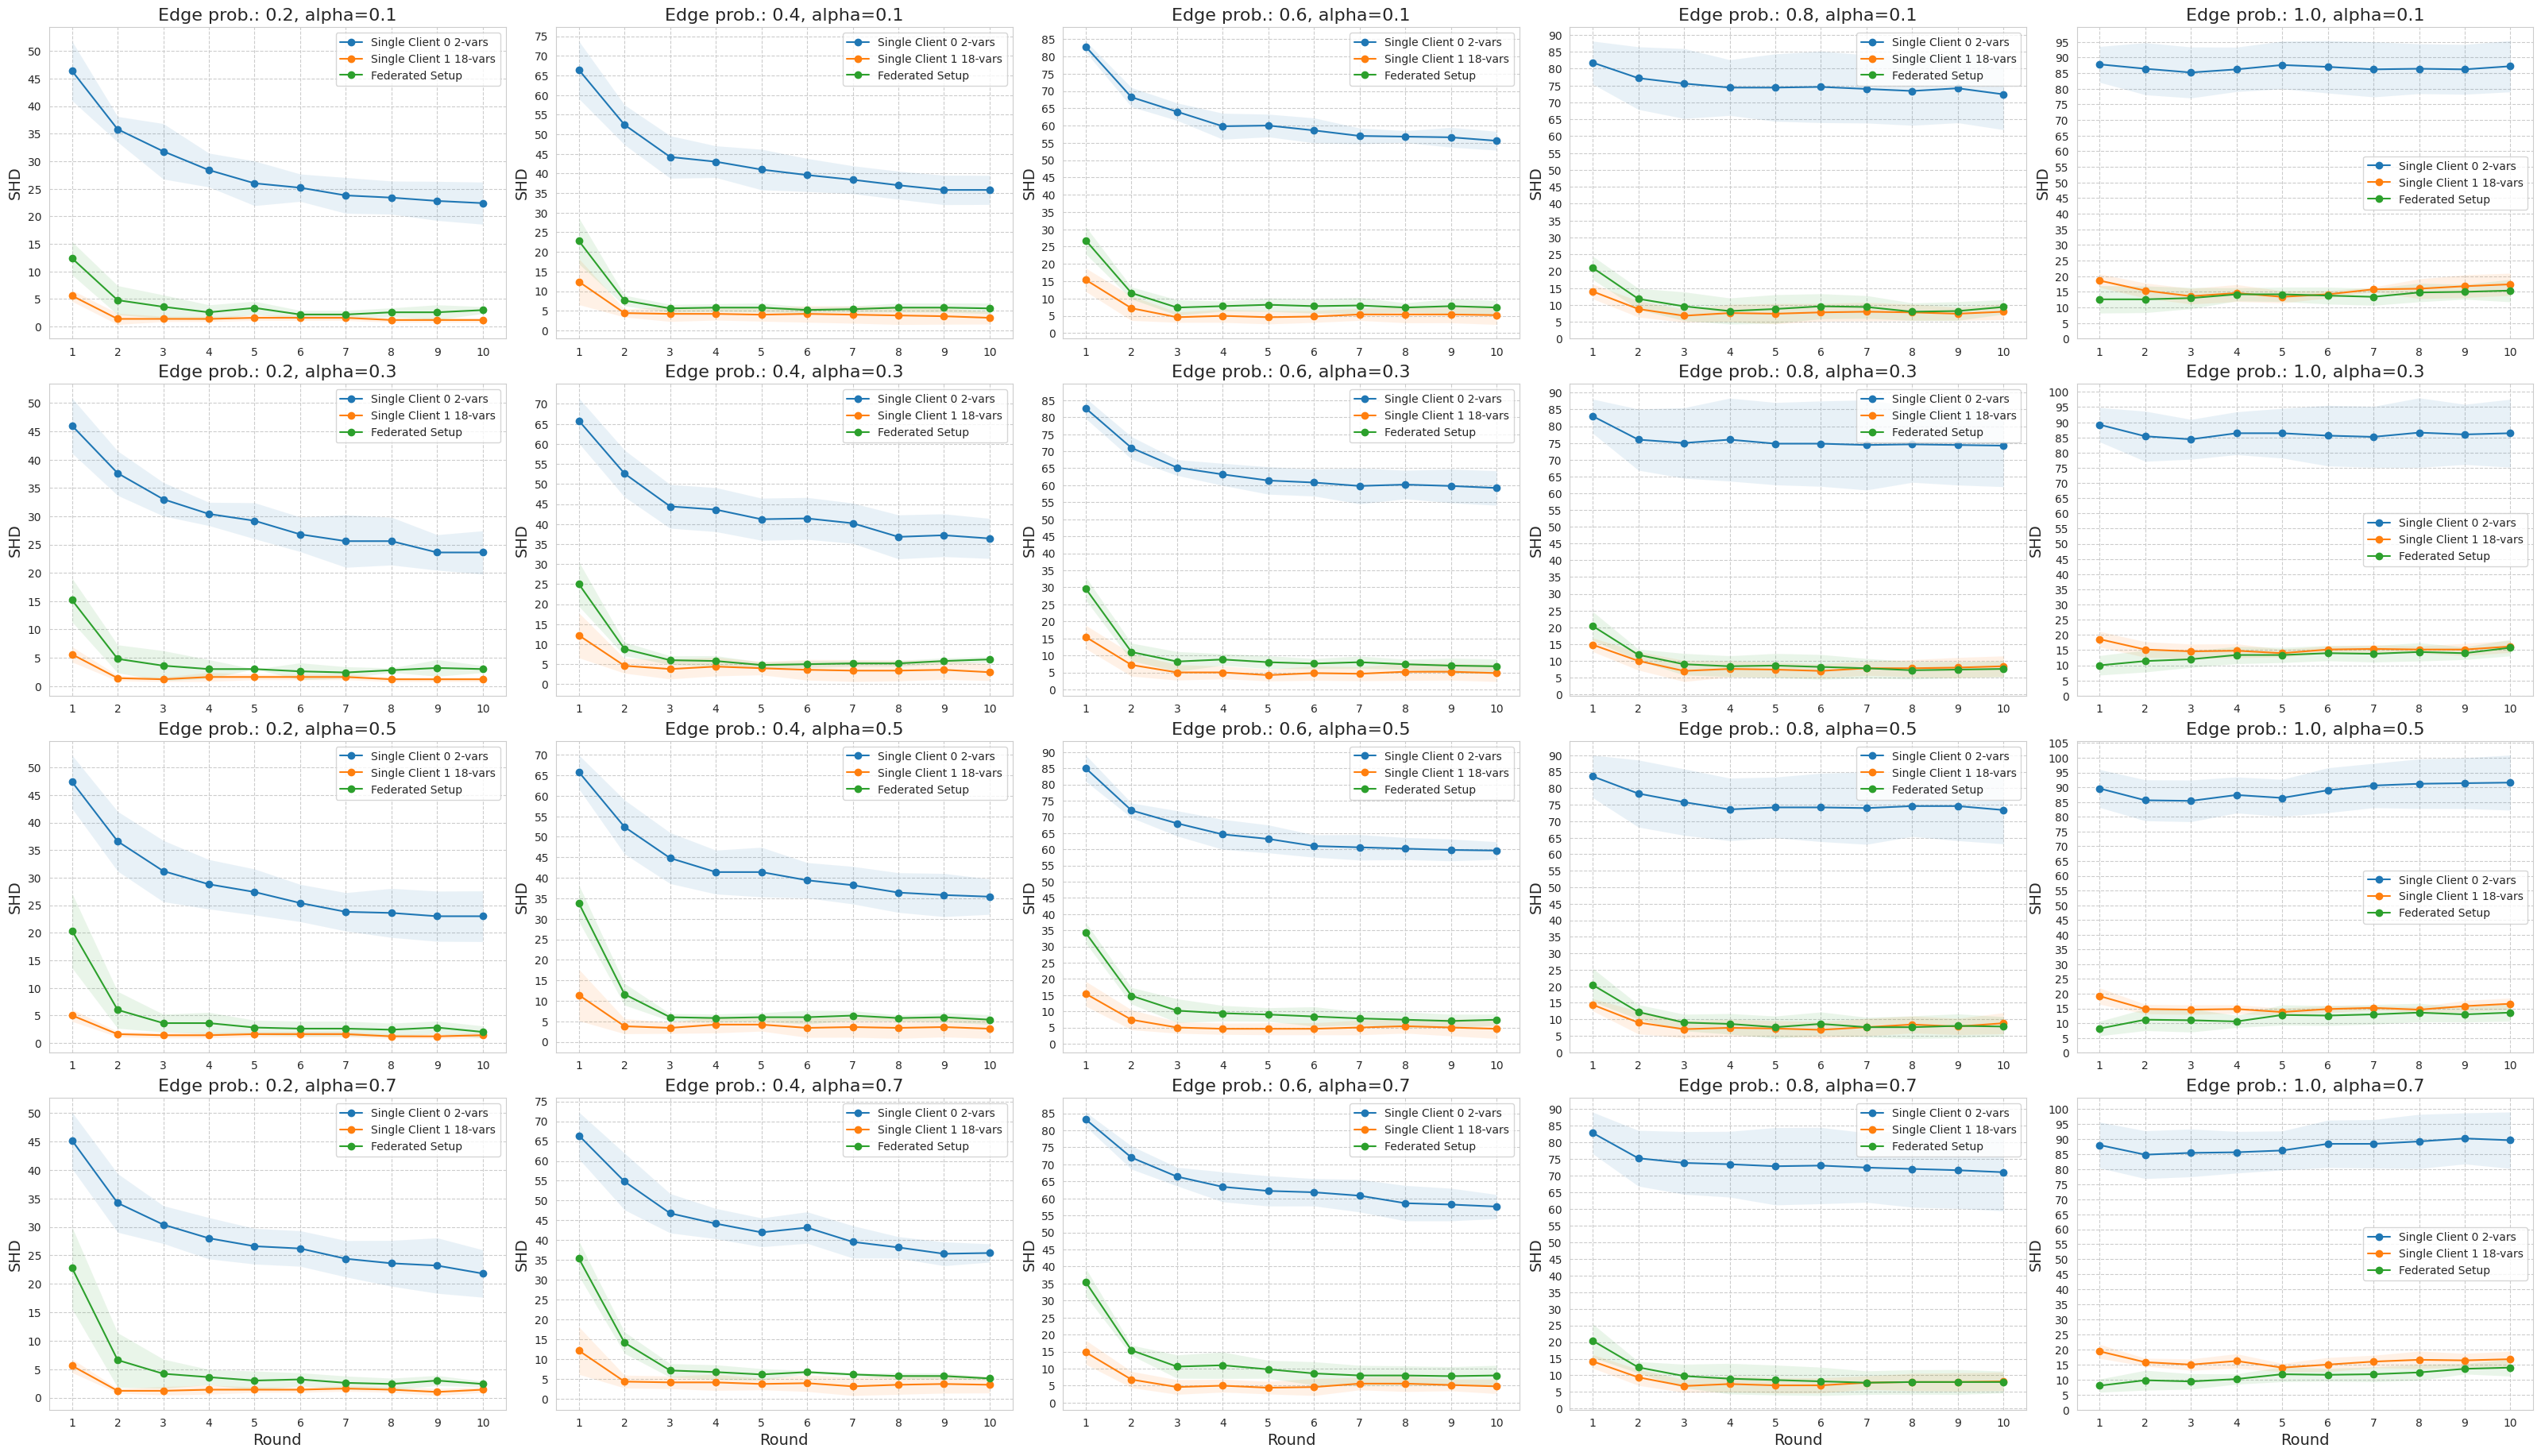

In [12]:
# General Setup
num_experiments, num_rounds, repeat_count, plot_metric, std_exageration = 3, 10, 5, "SHD", 1
num_vars = 20

# Specific Setup
experiment_graphs = "rnd"
splits = [(10, 90)]

# Graphs
graph_types = ["chain", "jungle", "full", "collider", "bidiag"]  
edge_probs = [0.2, 0.4, 0.6, 0.8, 1.0]
alphas = [0.1, 0.3, 0.5, 0.7]

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "Graph type: " if experiment_graphs == "str" else "Edge prob.: "

intervention_labels = list()
for split in splits:
    intervention_labels.append([f'Single Client 0 {int((split[0] / 100) * num_vars)}-vars', 
                                f'Single Client 1 {int((split[1] / 100) * num_vars)}-vars', 
                                "Federated Setup"])

parent_folder_name = 'alpha_search/rnd_search'
specifiers = alphas

n_row = len(specifiers)
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(32, 18), dpi=100)
fig.tight_layout(h_pad=2, w_pad=1.5)

for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        axs[row, col].set_title(f'{title}{graph}, alpha={specifier}', fontsize=16)
        folder_name = f'ToySetup-{graph}-{num_vars}-alpha-aps-10-90-{specifier}'

        plot_cluster_experiments_subplots(axs, (row, col), num_experiments, repeat_count, 
                                          intervention_labels[row], parent_folder_name, 
                                          exps_folder_name, plot_target='priors')

# plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Plot graphs per round

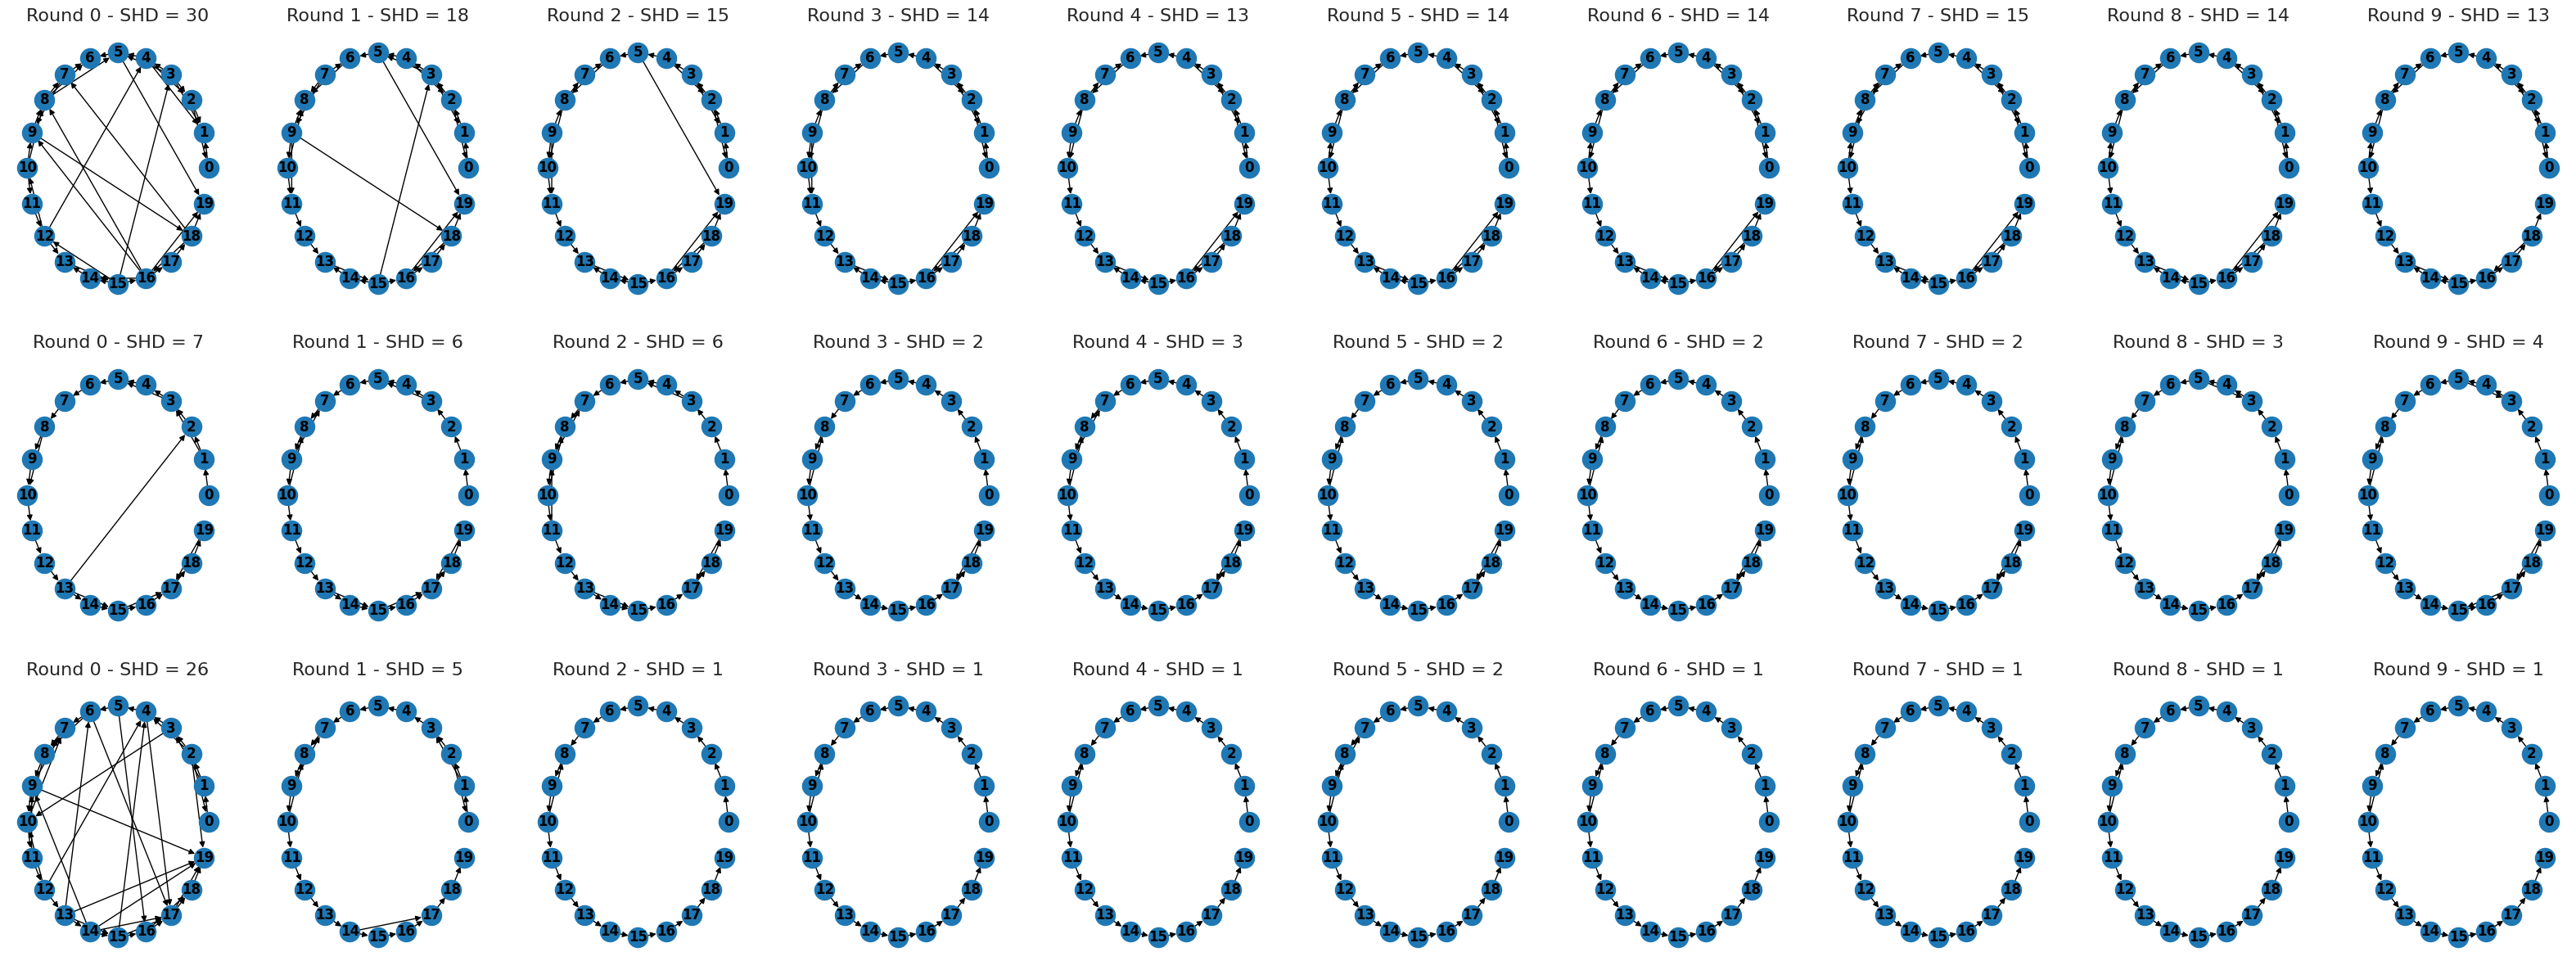

In [16]:
num_rounds = 10
rounds = np.arange(start=0, stop=num_rounds, step=1)

folder_name = "str_toy/ToySetup-chain-20-aps-20-80"
setups = ["Client-0", "Client-1", "Federated Setup"]
n_row = len(setups)
n_col = num_rounds

fig, axs = plt.subplots(n_row, n_col, figsize=(32, 12), dpi=100)
fig.tight_layout(h_pad=2, w_pad=0.5)

for r, setup in enumerate(setups):
    data_file_name = f'results_{r}_1.pickle'
    load_dir = os.path.join('data', folder_name, data_file_name)
    
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    setup_mats = results_dict['round_adjs']
    setup_shds = results_dict['round_metrics']

    for c in range(n_col):
        graph = nx.DiGraph(setup_mats[c])
        nx.draw_circular(graph, ax=axs[r, c], with_labels=True, font_weight='bold')
        axs[r, c].set_title(f'Round {c} - SHD = {setup_shds[c]["SHD"]}', fontsize=16)
        axs[r, c].set_axis_off()


plt.savefig(f'unbalanced_int_graph_plots.png', bbox_inches='tight')
plt.show()
    


### Average entropy analysis

10
(50, 50)
[array([[0.        , 0.        , 0.        , ..., 0.9456603 , 0.43949699,
        0.43949699],
       [0.        , 0.        , 0.        , ..., 0.68403844, 0.84535094,
        0.9456603 ],
       [0.        , 0.        , 0.        , ..., 0.84535094, 0.9456603 ,
        0.43949699],
       ...,
       [0.84535094, 0.68403844, 0.43949699, ..., 0.        , 0.68403844,
        0.84535094],
       [0.43949699, 0.43949699, 0.99403021, ..., 0.68403844, 0.        ,
        0.68403844],
       [0.43949699, 0.9456603 , 0.43949699, ..., 0.        , 0.        ,
        0.        ]]), array([[0.        , 0.        , 0.        , ..., 0.68403844, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.68403844, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.68403844, 0.84535094,
        0.        ],
       ...,
       [0.68403844, 0.68403844, 0.        , ..., 0.        , 0.84535094,
        0.99403021],
       [0.        , 0

10
(50, 50)
[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.43949699,
        0.        ],
       ...,
       [0.        , 0.        , 0.43949699, ..., 0.        , 0.68403844,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.9456603 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.43949699, ..., 0.        , 0.        ,
        0.        ]]), array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0

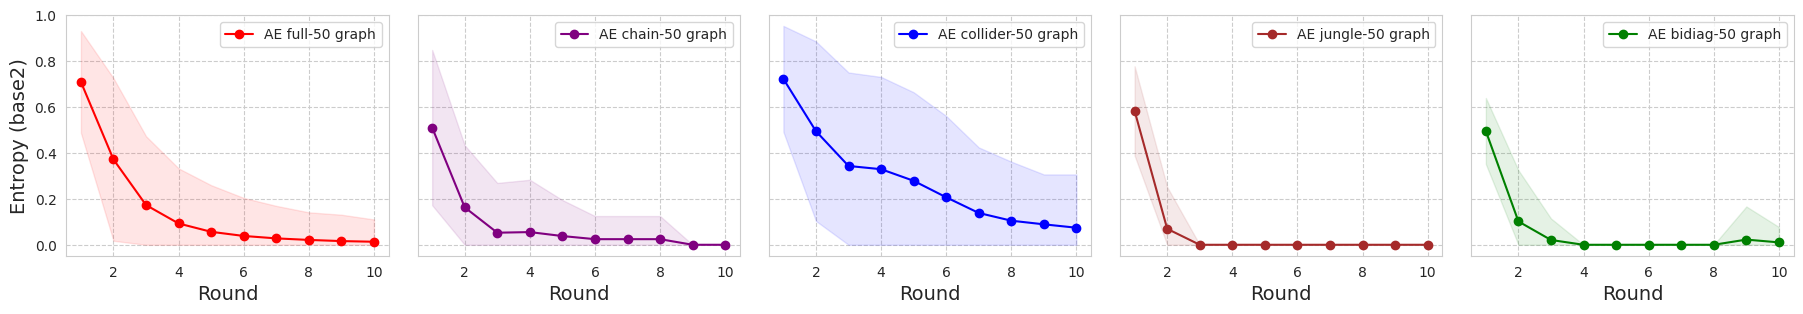

In [7]:
parent_folder_name = 'entropy_tests'

num_rounds = 10
num_clients = 10

fig, axs = plt.subplots(1, 5, figsize=(18, 3), dpi=100, sharex='all', sharey='all')
fig.tight_layout(h_pad=2, w_pad=0.5)

colors = ['red', 'purple', 'blue', 'brown', 'green']
for idx, graph_type in enumerate(["full", "chain", "collider", "jungle", "bidiag"]):
    folder_name = f'Graph10-{graph_type}-50'
    row = idx // 2
    col = idx % 5

    data_file_name = 'results_4_0.pickle'
    if graph_type == 'bidiag':
        data_file_name = 'results_10_0.pickle'
    load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    entropy_matrices = list()
    for round_id in range(num_rounds): 
        entropy_matrices.append(calculate_edge_entropy(results_dict['matrices'][round_id]))
    
    print(len(entropy_matrices))
    print(entropy_matrices[0].shape)
    print(entropy_matrices)
    mat_size = entropy_matrices[0].shape[0]
    entropy_vals = [mat.ravel() for mat in entropy_matrices]
    plot_mat = np.stack((entropy_vals)).T

    rounds = [round_id for round_id in range(1, 10 + 1)]
    rows = [row for row in range(mat_size * mat_size) if row % mat_size > mat_size / 2 and np.average(plot_mat[row]) > 0.01]
    print(f'Total edges to plot: {len(rows)}')

    avgs_entropy = np.average(plot_mat[rows], axis=0)
    stds_entropy = np.std(plot_mat[rows], axis=0)
    
    axs[col].plot(rounds, avgs_entropy, marker='o', color=colors[idx], label=f'AE {graph_type}-50 graph')
    axs[col].fill_between(rounds, [0 if el < 0 else el for el in avgs_entropy - stds_entropy],
                               (avgs_entropy + stds_entropy), alpha=0.1, color=colors[idx])
    

    axs[0].set_ylabel("Entropy (base2)", fontsize=14)

    axs[col].legend(loc='upper right')
    axs[col].set_xlabel('Round', fontsize=14)

    plt.savefig(f'entropy_analysis_str_graphs.png', bbox_inches='tight')

plt.show()

Total edges to plot: 22
Total edges to plot: 16
Total edges to plot: 34
Total edges to plot: 31
Total edges to plot: 39


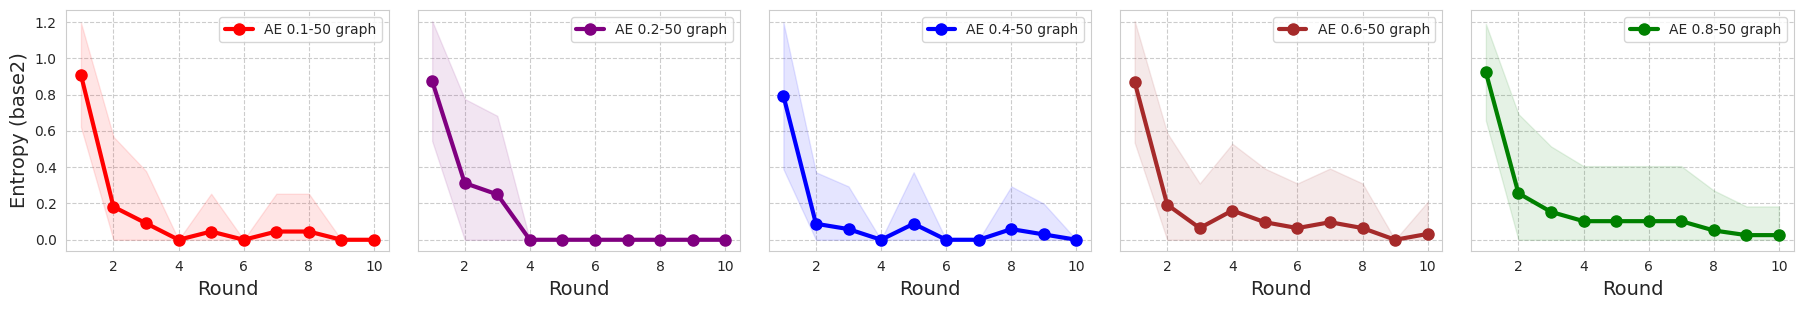

In [17]:
parent_folder_name = 'entropy_tests'

num_rounds = 10
num_clients = 10

fig, axs = plt.subplots(1, 5, figsize=(18, 3), dpi=100, sharex='all', sharey='all')
fig.tight_layout(h_pad=2, w_pad=0.5)

colors = ['red', 'purple', 'blue', 'brown', 'green']
for idx, edge_prob in enumerate([0.1, 0.2, 0.4, 0.6, 0.8]):
    folder_name = f'BalancedSetup-{edge_prob}-20-5'
    col = idx % 5

    data_file_name = 'results_1_2.pickle'
    if edge_prob == 0.4: data_file_name = 'results_1_0.pickle'
    if edge_prob == 0.6: data_file_name = 'results_1_1.pickle'

    load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    entropy_matrices = list()
    for round_id in range(num_rounds): 
        entropy_matrices.append(calculate_edge_entropy([results_dict['client_0_adjs'][round_id], results_dict['client_1_adjs'][round_id]]))

    mat_size = entropy_matrices[0].shape[0]
    entropy_vals = [mat.ravel() for mat in entropy_matrices]
    plot_mat = np.stack((entropy_vals)).T

    rounds = [round_id for round_id in range(1, 10 + 1)]
    rows = [row for row in range(mat_size * mat_size) if row % mat_size > mat_size / 2 and np.average(plot_mat[row]) > 0.01]
    print(f'Total edges to plot: {len(rows)}')

    avgs_entropy = np.average(plot_mat[rows], axis=0)
    stds_entropy = np.std(plot_mat[rows], axis=0)
    
    axs[col].plot(rounds, avgs_entropy, marker='o', color=colors[idx], markersize=8, linewidth=3, label=f'AE {edge_prob}-50 graph')
    axs[col].fill_between(rounds, [0 if el < 0 else el for el in avgs_entropy - stds_entropy],
                               (avgs_entropy + stds_entropy), alpha=0.1, color=colors[idx])
    

    axs[0].set_ylabel("Entropy (base2)", fontsize=14)

    axs[col].legend(loc='upper right')
    axs[col].set_xlabel('Round', fontsize=14)

    plt.savefig(f'entropy_analysis_str_graphs.png', bbox_inches='tight')

plt.show()